In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random

In [2]:
""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [7]:
_lambda = 578e-9
omega_r = 2*np.pi*8e3
m = 171*u
tau = 22

k = 2*np.pi/_lambda #momentum kick 
x0 = np.sqrt(hbar/2/m/omega_r) #oscillator length
LambDicke = x0*k #Lamb-Dicke parameters
print('Lamb-Dicke parameter (eta): ', LambDicke)
print('eta^2 (2n+1): ', LambDicke**2, '(2n+1)')
print('Max n for Lamb-Dicke regime: n = ', floor(((1/LambDicke**2)-1)/2))

Lamb-Dicke parameter (eta):  0.6607201946347716
eta^2 (2n+1):  0.4365511755982105 (2n+1)
Max n for Lamb-Dicke regime: n =  0


In [8]:
N=20 #keep HO states up to N 
#delta = 0
#Omega_ls = [2*np.pi*115e3]

#define operators
i = qutip.tensor(identity(N), identity(2))
a = qutip.tensor(destroy(N), identity(2))
adag = qutip.tensor(create(N), identity(2))
sm = qutip.tensor(identity(N), sigmam())
sp = qutip.tensor(identity(N), sigmap())
sz = qutip.tensor(identity(N), sigmaz())

up = basis(2,1)
down = basis(2,0)
ground = fock(N, 0)
up_proj = qutip.tensor(identity(N), up*up.dag())
down_proj = qutip.tensor(identity(N), down*down.dag())
ground_proj = qutip.tensor(ground*ground.dag(), identity(2))

# Continuous Rabi drive

In [37]:
#hamiltonian
H_ls = []
for Omega in Omega_ls:
    HO = omega_r*(adag*a + 1/2)
    HA = -delta/2*sz
    HC = Omega/2* ( (1j*LambDicke*(adag+a)).expm()*(sp) + (-1j*LambDicke*(adag+a)).expm()*(sm) )
    H = HC+HO+HA
    H_ls.append(H)

In [38]:
T=1e-6 #initial temperature
omega_r_deep = 2*np.pi*63e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), down*down.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', rho0.diag()[0])

True
n_start:  0.05111530367346818
ground state population 0.9513704124610985


In [39]:
c_ops_ls = []

In [40]:
result_ls = []
tlist_ls = []
for i in range(len(H_ls)):
    H = H_ls[i]
    Omega = Omega_ls[i]
    c_ops = c_ops_ls
        
    timescale = 2*pi/Omega

    ti, tf, dt = 0, 30e-6, timescale/1e3
    tlist = np.arange(ti,tf,dt)
    tlist_ls.append(tlist)
    options = qutip.solver.Options(nsteps=100000)
    result = mesolve(H, rho0, tlist, c_ops=c_ops, options=options)
    result_ls.append(result)

In [41]:
Pg_ls = []
Pup_ls = []
for i, result in enumerate(result_ls):
    rho_ls = result.states
#nbar = [(adag*a*rho).tr() for rho in rho_ls]
    Pup = [(up_proj*rho).tr() for rho in rho_ls]
    Pup_ls=Pup
#Pdown = [(down_proj*rho).tr() for rho in rho_ls]
    Pg = [(ground_proj*rho).tr() for rho in rho_ls]
    Pg_ls = Pg

Text(0, 0.5, 'Pg')

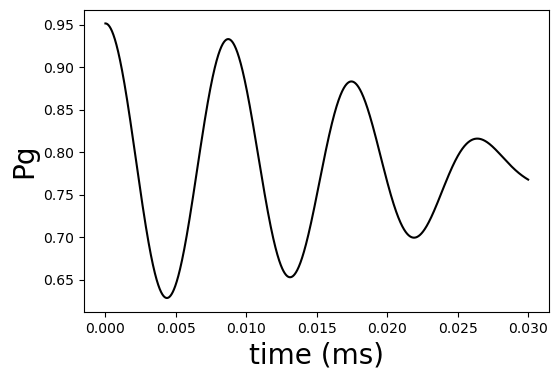

In [42]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(tlist*1e3, Pg, color='k', linestyle='-')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'Pg', fontsize=20)

(0.0, 1.0)

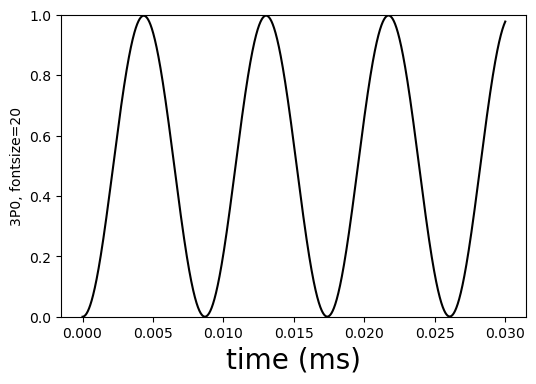

In [46]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(tlist*1e3, Pup, color='k', linestyle='-')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'3P0, fontsize=20')
axes.set_ylim(0.0,1)
#print(1-max(Pup))

# Two pulses + wait time

In [47]:
Omega = 2*np.pi*115e3
delta = 2*np.pi*42e3
omega_r = 2*np.pi*8e3

#hamiltonian
HO = omega_r*(adag*a + 1/2)
HA = -delta/2*sz
HC = Omega/2* ( (1j*LambDicke*(adag+a)).expm()*(sp) + (-1j*LambDicke*(adag+a)).expm()*(sm) )
H_driven = HC+HO

H_wait = HO+HA

In [48]:
T=1e-6 #initial temperature
omega_r_deep = 2*np.pi*60e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), down*down.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', rho0.diag()[0])

True
n_start:  0.0595019051802481
ground state population 0.9438397374376355


In [49]:
c_ops = []

In [53]:
result_ls = []
pi_pulse = 2*pi/Omega/2

twait_ls = np.arange(.02e-6, 1000e-6, .2e-6)
ti, tf, dt = 0, .1e-3, .01e-3
tlist = np.arange(ti,tf,dt)


for twait in twait_ls:
    
    options = qutip.solver.Options(nsteps=100000)
    
    result0 = mesolve(H_driven, rho0, np.arange(0,pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
    rho1 = result0.states[-1]
    
    result1 = mesolve(H_wait, rho1, np.arange(pi_pulse, pi_pulse+twait, pi_pulse/4e1), c_ops=c_ops, options=options)
    rho2 = result1.states[-1]
    
    result2 = mesolve(H_driven, rho2, np.arange(pi_pulse+twait,twait+2*pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
    rho2 = result2.states[-1]
 
    result_ls.append(rho2)

In [51]:
Pg_ls = []
Pup_ls = []
for i, result in enumerate(result_ls):
    rho = result
    #print(rho_ls)
#nbar = [(adag*a*rho).tr() for rho in rho_ls]
    Pup = (up_proj*rho).tr()
    Pup_ls.append(Pup)
#Pdown = [(down_proj*rho).tr() for rho in rho_ls]
    Pg = (ground_proj*rho).tr()
    Pg_ls.append(Pg)

Text(0, 0.5, 'Pg')

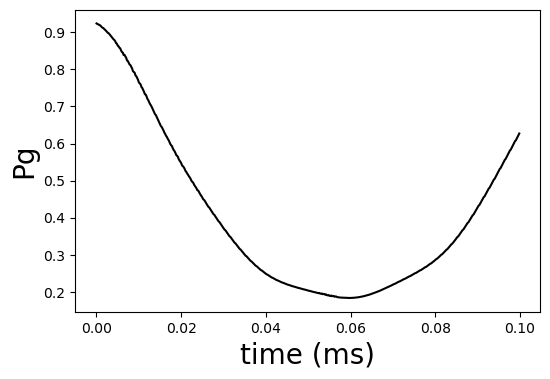

In [52]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(twait_ls*1e3, Pg_ls, color='k', linestyle='-')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'Pg', fontsize=20)

Text(0, 0.5, '1P0')

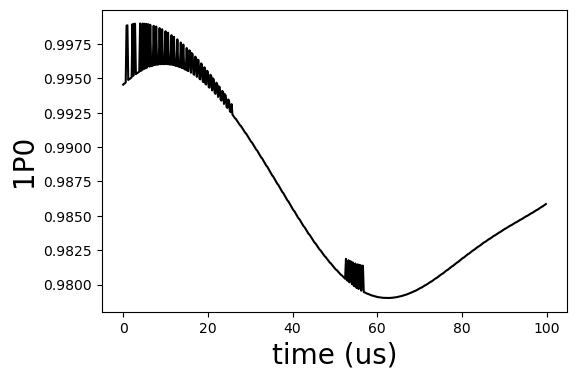

In [36]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(twait_ls*1e6, np.subtract(1, Pup_ls), color='k', linestyle='-')
axes.set_xlabel(r'time (us)', fontsize=20)
axes.set_ylabel(r'1P0', fontsize=20)
#axes.set_ylim(0.95,1)

## max error as function of initial temperature

In [201]:
Omega = 2*np.pi*70e3

#hamiltonian
HO = omega_r*(adag*a + 1/2)
HA = -delta/2*sz
HC = Omega/2* ( (1j*LambDicke*(adag+a)).expm()*(sp) + (-1j*LambDicke*(adag+a)).expm()*(sm) )
H_driven = HC+HO+HA

H_wait = HO+HA

In [202]:
n_start = np.arange(0, 1, 0.1)
rho0_ls = []
for n in n_start:
    rho0 = qutip.tensor(thermal_dm(N, n), down*down.dag()) #start in up thermal state
    rho0_ls.append(rho0
                  )

In [203]:
c_ops = []

In [206]:
max_error = []
min_error = []

for rho0 in rho0_ls:    
    
    
    result_ls = []
    pi_pulse = 2*pi/Omega/2

    twait_ls = np.arange(.02e-3, .4e-3, .005e-3)
    ti, tf, dt = 0, .1e-3, .01e-3
    tlist = np.arange(ti,tf,dt)


    for twait in twait_ls:

        options = qutip.solver.Options(nsteps=100000)

        result0 = mesolve(H_driven, rho0, np.arange(0,pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
        rho1 = result0.states[-1]

        result1 = mesolve(H_wait, rho1, np.arange(pi_pulse, pi_pulse+twait, pi_pulse/4e1), c_ops=c_ops, options=options)
        rho2 = result1.states[-1]

        result2 = mesolve(H_driven, rho2, np.arange(pi_pulse+twait,twait+2*pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
        rho2 = result2.states[-1]

        result_ls.append(rho2)
        
        
    Pg_ls = []
    Pup_ls = []
    for i, result in enumerate(result_ls):
        rho = result
    #print(rho_ls)
    #nbar = [(adag*a*rho).tr() for rho in rho_ls]
        Pup = (up_proj*rho).tr()
        Pup_ls.append(Pup)
    #Pdown = [(down_proj*rho).tr() for rho in rho_ls]
        Pg = (ground_proj*rho).tr()
        Pg_ls.append(Pg)
    
    max_error.append(max(Pup_ls))
    min_error.append(min(Pup_ls))
    

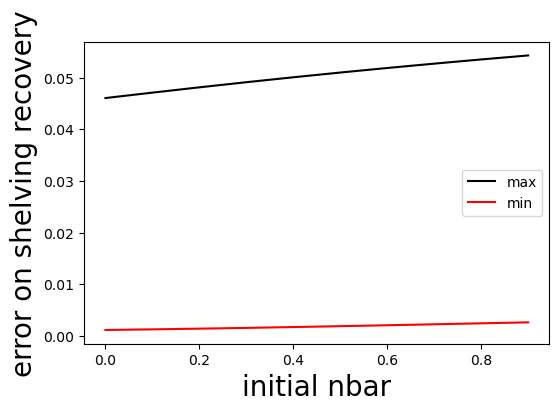

In [207]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(n_start, max_error, color='k', linestyle='-', label='max')
axes.plot(n_start, min_error, color='r', linestyle='-', label='min')
axes.set_xlabel(r'initial nbar', fontsize=20)
axes.set_ylabel(r'error on shelving recovery', fontsize=20)
plt.legend()
#axes.set_ylim(0.95,1)

## max error as function of Rabi

In [119]:
T=3e-6 #initial temperature
omega_r_deep = 2*np.pi*60e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), down*down.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', rho0.diag()[0])

c_ops = []

Omega_ls = 2*np.pi*70e3*np.linspace(1, np.sqrt(1/.02), 10)

max_error = []
min_error = []

#hamiltonian
for Omega in Omega_ls:
    HO = omega_r*(adag*a + 1/2)
    HA = -delta/2*sz
    HC = Omega/2* ( (1j*LambDicke*(adag+a)).expm()*(sp) + (-1j*LambDicke*(adag+a)).expm()*(sm) )
    H_driven = HC+HO+HA

    H_wait = HO+HA


    result_ls = []
    pi_pulse = 2*pi/Omega/2

    twait_ls = np.arange(.02e-6, 1e-6, .005e-6)
    ti, tf, dt = 0, .1e-3, .01e-3
    tlist = np.arange(ti,tf,dt)


    for twait in twait_ls:

        options = qutip.solver.Options(nsteps=100000)

        result0 = mesolve(H_driven, rho0, np.arange(0,pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
        rho1 = result0.states[-1]

        result1 = mesolve(H_wait, rho1, np.arange(pi_pulse, pi_pulse+twait, pi_pulse/4e1), c_ops=c_ops, options=options)
        rho2 = result1.states[-1]

        result2 = mesolve(H_driven, rho2, np.arange(pi_pulse+twait,twait+2*pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
        rho2 = result2.states[-1]

        result_ls.append(rho2)


    Pg_ls = []
    Pup_ls = []
    for i, result in enumerate(result_ls):
        rho = result
    #print(rho_ls)
    #nbar = [(adag*a*rho).tr() for rho in rho_ls]
        Pup = (up_proj*rho).tr()
        Pup_ls.append(Pup)
    #Pdown = [(down_proj*rho).tr() for rho in rho_ls]
        Pg = (ground_proj*rho).tr()
        Pg_ls.append(Pg)

    max_error.append(max(Pup_ls))
    min_error.append(min(Pup_ls))


True
n_start:  0.6206164576377906
ground state population 0.6170910033855942


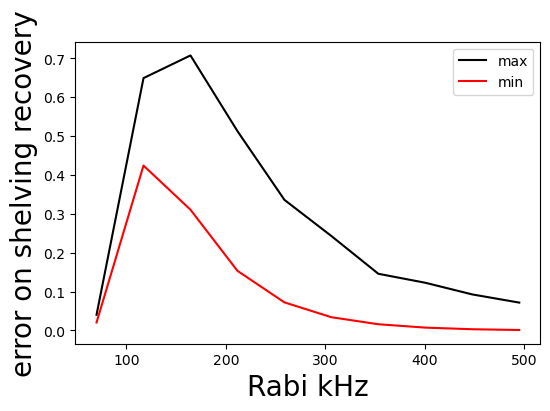

In [120]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(Omega_ls/2/np.pi/1e3, max_error, color='k', linestyle='-', label='max')
axes.plot(Omega_ls/2/np.pi/1e3, min_error, color='r', linestyle='-', label='min')
axes.set_xlabel(r'Rabi kHz', fontsize=20)
axes.set_ylabel(r'error on shelving recovery', fontsize=20)
plt.legend()
#axes.set_ylim(0.95,1)

# Two pulses + wait time

In [23]:
Omega = 2*np.pi*115e3
delta = 0

#hamiltonian
HO = omega_r*(adag*a + 1/2)
HA = -delta/2*sz
HC = Omega/2* ( (1j*LambDicke*(adag+a)).expm()*(sp) + (-1j*LambDicke*(adag+a)).expm()*(sm) )
H_driven = HC+HO

H_wait = HO+HA

In [24]:
T=1e-6 #initial temperature
omega_r_deep = 2*np.pi*60e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), down*down.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', rho0.diag()[0])

True
n_start:  0.0595019051802481
ground state population 0.9438397374376355


In [25]:
c_ops = []

In [26]:
result_ls = []
pi_pulse = 2*pi/Omega/2

twait_ls = np.arange(1e-12, 400e-3, 1e-3)
ti, tf, dt = 1e-9, 0.5e-6, 1e-9
tlist = np.arange(ti,tf,dt)


for twait in twait_ls:
    
    options = qutip.solver.Options(nsteps=100000)
    
    result0 = mesolve(H_driven, rho0, np.arange(0,pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
    rho1 = result0.states[-1]
    
    result1 = mesolve(H_wait, rho1, np.arange(pi_pulse, pi_pulse+twait, pi_pulse/4e1), c_ops=c_ops, options=options)
    rho2 = result1.states[-1]
    
    result2 = mesolve(H_driven, rho2, np.arange(pi_pulse+twait,twait+2*pi_pulse,pi_pulse/4e1), c_ops=c_ops, options=options)
    rho2 = result2.states[-1]
 
    result_ls.append(rho2)

KeyboardInterrupt: 

In [18]:
Pg_ls = []
Pup_ls = []
for i, result in enumerate(result_ls):
    rho = result
    #print(rho_ls)
#nbar = [(adag*a*rho).tr() for rho in rho_ls]
    Pup = (up_proj*rho).tr()
    Pup_ls.append(Pup)
#Pdown = [(down_proj*rho).tr() for rho in rho_ls]
    Pg = (ground_proj*rho).tr()
    Pg_ls.append(Pg)

Text(0, 0.5, 'Pg')

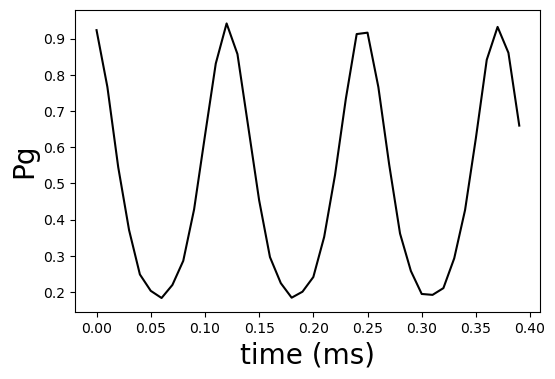

In [19]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(twait_ls*1e3, Pg_ls, color='k', linestyle='-')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'Pg', fontsize=20)

(0.35, 0.45)

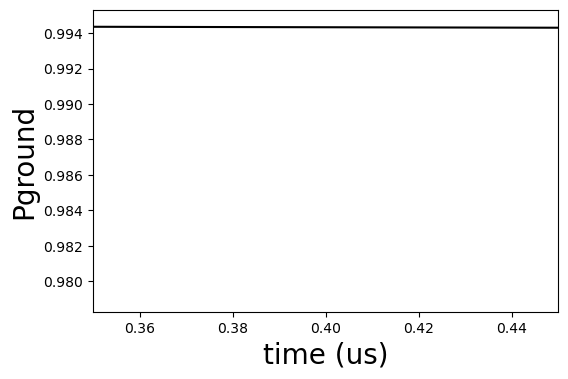

In [21]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(twait_ls*1e6, np.subtract(1, Pup_ls), color='k', linestyle='-')
axes.set_xlabel(r'time (us)', fontsize=20)
axes.set_ylabel(r'Pground', fontsize=20)
axes.set_xlim(0.35, 0.45)

In [106]:
omega_r/2/np.pi

7999.999999999999

# N pulses + wait time

In [116]:
Omega = 2*np.pi*115e3
delta = 2*np.pi*50e3
omega_r = 2*np.pi*8e3

#hamiltonian
HO = omega_r*(adag*a + 1/2)
HA = -delta/2*sz
HC = Omega/2* ( (1j*LambDicke*(adag+a)).expm()*(sp) + (-1j*LambDicke*(adag+a)).expm()*(sm) )
H_driven = HC+HO

H_wait = HO+HA

In [117]:
T=8e-6 #initial temperature
omega_r_deep = 2*np.pi*60e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), down*down.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', rho0.diag()[0])

True
n_start:  2.308146582121228
ground state population 0.31078057016528127


In [118]:
c_ops = []

In [119]:
result_ls = []
pi_pulse = 2*pi/Omega/2

twait = 0.4e-6
ti, tf, dt = 0, .1e-3, .01e-3
tlist = np.arange(ti,tf,dt)
n_ls = np.arange(2, 70)


for n in n_ls:
    
    options = qutip.solver.Options(nsteps=100000)
    rho0 = qutip.tensor(thermal_dm(N, n_start), down*down.dag()) #start in up thermal state
    i = 0
    while i<n:
    
        result0 = mesolve(H_driven, rho0, np.arange(0,pi_pulse,pi_pulse/1e2), c_ops=c_ops, options=options)
        rho1 = result0.states[-1]
    
        result1 = mesolve(H_wait, rho1, np.arange(pi_pulse, pi_pulse+twait, pi_pulse/1e2), c_ops=c_ops, options=options)
        
        i += 1
        rho0 = result1.states[-1]
  
    result_ls.append(rho0)

In [120]:
Pg_ls = []
Pup_ls = []
for i, result in enumerate(result_ls):
    rho = result
    #print(rho_ls)
#nbar = [(adag*a*rho).tr() for rho in rho_ls]
    Pup = (up_proj*rho).tr()
    Pup_ls.append(Pup)
#Pdown = [(down_proj*rho).tr() for rho in rho_ls]
    Pg = (ground_proj*rho).tr()
    Pg_ls.append(Pg)

Text(0, 0.5, 'Pg')

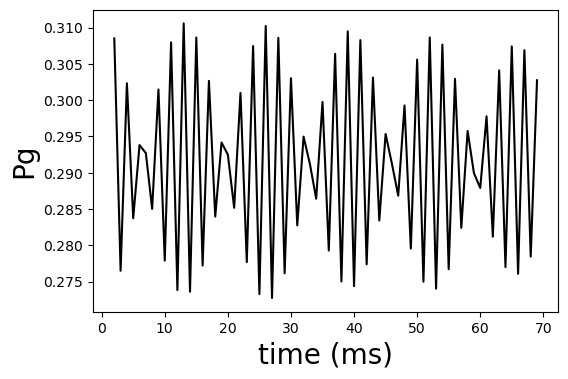

In [121]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(n_ls, Pg_ls, color='k', linestyle='-')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'Pg', fontsize=20)

(0.0, 0.22)

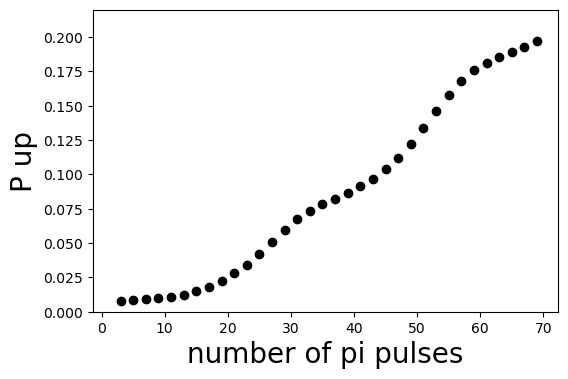

In [113]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True)

axes.plot(n_ls, np.subtract(1, Pup_ls), color='k', marker='o', linestyle='none')
axes.set_xlabel(r'number of pi pulses', fontsize=20)
axes.set_ylabel(r'P up', fontsize=20)
axes.set_ylim(0, 0.22)

In [92]:
115/15

7.666666666666667

In [115]:
np.exp(-60/10e3)

0.9940179640539353

In [114]:
.75/2

0.375